In [1]:
import pandas as pd
import os
import seaborn as sn
import matplotlib as mpl
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score
import pickle
sn.set_theme()
mpl.rcParams['figure.dpi'] = 300
sn.set_style("whitegrid")
import numpy as np
from matplotlib import pyplot as plt
from Bio.pairwise2 import format_alignment
from Bio import pairwise2

anno = pd.read_csv('data/scraped_annotations.csv')
binding_db = pd.read_csv('data/binding_db.csv')

C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10,11,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
def realign(preds, truth, dist=2):
    # Produce different shifts for the `preds` array
    pad_preds = np.pad(preds, [(dist, dist)])
    shift_preds = []
    shift_array = np.concatenate([np.arange(-dist, 0), np.arange(1, dist + 1)])
    for ii in shift_array:
        this_preds = np.pad(pad_preds.copy(), [(0, 1)])
        shift_preds.append(this_preds[dist - ii:-dist - ii - 1] * truth)

    # Shift the `preds` array according to the maximum intersection with the truth
    EPS = 1e-8
    eps = np.zeros_like(shift_preds[0]) + EPS
    shift_preds = np.stack([eps] + shift_preds, axis=0)
    shift_idx = np.argmax(shift_preds, axis=0)
    shift_idx[shift_idx == 0] = -1
    shift_preds = np.concatenate([shift_preds, preds.reshape(1, *preds.shape)], axis=0)
    preds2 = shift_preds[shift_idx, np.arange(shift_preds.shape[1])]

    # Find the values that were shifted, and replace them by ~0
    shift_factor = np.array([shift_array[idx - 1] if idx >= 0 else 0 for idx in shift_idx])
    was_shifted = -shift_factor + np.arange(len(shift_factor))
    was_shifted = was_shifted[shift_factor != 0]
    preds2[was_shifted] = EPS

    # In case of intersection with the truth, keep the highest value to prevent bad shifts
    preds2[truth] = np.maximum(preds[truth], preds2[truth])
    return preds2


In [3]:
def binding_site_annotation(alignments_input, has_target_frame, input_sequence,misaligned_allowance):
    is_binding_site = np.zeros(len(input_sequence))
    for alignment, sequence, binding_sites in list(zip(alignments_input, has_target_frame['sequence'],
                                                       has_target_frame['Binding site residues1'])):
        if alignment['score']< len(input_sequence) * alignment_ratio or alignment['score'] < len(
                input_sequence) - misaligned_allowance: continue
        acids = []
        site_indices = []
        for site in binding_sites.split():
            acids.append(site[0])
            site_indices.append(int(site[1:]) - 1)
        reverse_indices = site_indices[::-1]
        annotated_count = 0
        to_annotate_count = 0
        target_sequence = ''
        target_sequence_annotations = ''
        annotated_sequence_annotations = ''
        annotated_sequence_annotations_manual = ''
        align_annotation_annotated_sequence = ''
        align_annotation_target = ''
        for i in range(len(is_binding_site)):
            if i in reverse_indices:
                annotated_sequence_annotations += '1'
            else:
                annotated_sequence_annotations += '0'

        for annotated, to_annotate in list(zip(alignment['seq1'], alignment['seq2'])):
            if len(reverse_indices) == 0: break
            is_binding_idx = False
            if reverse_indices[-1] == annotated_count and annotated != '-':
                reverse_indices.pop()
                is_binding_idx = True

            if to_annotate != '-':
                if is_binding_idx:
                    is_binding_site[to_annotate_count] = 1
                    target_sequence_annotations += '1'
                    align_annotation_target += '1'
                else:
                    target_sequence_annotations += '0'
                    align_annotation_target += '0'
                target_sequence += to_annotate
                to_annotate_count += 1
            else:
                align_annotation_target += '-'

            if annotated != '-':
                if is_binding_idx:
                    align_annotation_annotated_sequence += '1'
                    annotated_sequence_annotations_manual += '1'
                else:
                    align_annotation_annotated_sequence += '0'
                    annotated_sequence_annotations_manual += '0'
                annotated_count += 1
            else:
                align_annotation_annotated_sequence += '-'

        #print(align_annotation_target)
        #print(alignment['seq1'])
        #print(alignment['seq2'])
        #print(align_annotation_annotated_sequence)
        #print(target_sequence_annotations)
        #print(target_sequence)
        #print(sequence)
        #print(annotated_sequence_annotations)
        #print(annotated_sequence_annotations_manual)
        #print('\n')
    return is_binding_site

In [4]:
import os
import yaml
from zipfile import ZipFile

FILE_BEFORE = "metrics_before_finetune.yaml"
FILE_AFTER = "metrics.yaml"

def get_metrics_from_zipfile(path):
    with ZipFile(path) as zip:
        all_files = list(zip.namelist())
        metrics_before, metrics_after = {}, {}
        for file in tqdm(all_files):
            path = os.path.dirname(file)
            filename = os.path.basename(file)
            if filename == FILE_BEFORE:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_before[path] = dic["best_epoch_metric_summaries"]["test"]
            elif filename == FILE_AFTER:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_after[path] = dic["best_epoch_metric_summaries"]["test"]
    return metrics_before, metrics_after

In [10]:
output_name = 'images_1head'
if not os.path.exists(output_name):
    os.mkdir(output_name)
input_name = 'finetune_all_lr0.0001_loss-mse-heads-4'
alignments_name = 'finetune_all_lr0.0001_loss-mse-heads-4'
input_name = 'binding_db_DGN_ESM_models_finetuned_finetune_all_head1_lr0.0001_loss-mse'

In [6]:
zip_name = 'binding_db_DGN_ESM_models_finetuned_finetune_all_lr0.0001_loss-mse_heads-4.zip'
zip_name = 'binding_db_DGN_ESM_models_finetuned_finetune_all_lr0.0001_loss-mse_heads-1.zip'
metrics_before, metrics_after = get_metrics_from_zipfile(zip_name)

100%|██████████| 17674/17674 [01:45<00:00, 167.20it/s]


In [16]:
names = os.listdir(f'data/{input_name}')
pearsonRs = []
for name in tqdm(names):
    try:
        pearsonRs.append(metrics_after[f'{input_name}/{name}/default/version_0']['pearsonr/test'])
    except:
        pearsonRs.append(0)


dict_keys(['finetune_all_lr0.0001_loss-mse/G-protein coupled receptor 6/default/version_0', 'finetune_all_lr0.0001_loss-mse/Homo sapiens phosphodiesterase 2A (PDE2A)/default/version_0', 'finetune_all_lr0.0001_loss-mse/Transient receptor potential cation channel subfamily V member 1/default/version_0', 'finetune_all_lr0.0001_loss-mse/Aminopeptidase/default/version_0', 'finetune_all_lr0.0001_loss-mse/Ketohexokinase/default/version_0', 'finetune_all_lr0.0001_loss-mse/Hepatocyte nuclear factor 4-alpha/default/version_0', 'finetune_all_lr0.0001_loss-mse/Pancreatic lipase/default/version_0', 'finetune_all_lr0.0001_loss-mse/HIV-1 Reverse Transcriptase Mutant (Y181C)/default/version_0', 'finetune_all_lr0.0001_loss-mse/Liver X Receptor beta (LXR-beta)/default/version_0', 'finetune_all_lr0.0001_loss-mse/MAPK-Activated Protein Kinase 2 (MK2)/default/version_0', 'finetune_all_lr0.0001_loss-mse/Cannabinoid receptor 1/default/version_0', 'finetune_all_lr0.0001_loss-mse/Cannabinoid receptor 1/Mu-type

100%|██████████| 1598/1598 [00:00<00:00, 102250.16it/s]

[0.7425566911697388, 0.55302894115448, 0.9657461643218994, 0.7409480810165405, 0.862271249294281, 0.7806737422943115, 0.6014503836631775, 0.8457728028297424, 0.6480026841163635, 0.8258175849914551, 0.9524254202842712, 0.5190318822860718, 0.8403860330581665, 0.7969418168067932, 0.4883832037448883, 0.8664279580116272, 0.6979007720947266, 0.5361363291740417, 0.693292498588562, 0.7654300928115845, 0.8584226369857788, 0.34431037306785583, 0.6616385579109192, 0.8394564986228943, 0.5943769216537476, 0.6722083687782288, 0.1992434710264206, 0.8833817839622498, 0.7122151255607605, 0.806354820728302, 0.8879094123840332, 0.7291128635406494, 0.8773555755615234, 0.7191356420516968, 0.7535088658332825, 0.2673546373844147, 0.8064825534820557, 0.93105548620224, 0.9883019924163818, 0.7910417318344116, 0.8214466571807861, 0.8933191299438477, 0, 0.9466059803962708, 0, 0.9680910706520081, 0.7427000403404236, 0.9082260727882385, 0.9217804074287415, 0.8518566489219666, 0.9447339177131653, 0.2565583288669586,

In [9]:

per_name_alignments = {}
for name, pearsonR in tqdm(list(zip(names, pearsonRs))):

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        per_name_alignments[name] =[]
        continue
    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))
    for query_idx, query_sequence in enumerate(query_sequences):
        seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
        complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
        complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
        if complex_ids == []: continue
        target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
        target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
        comp_and_target_ids = list(set(complex_ids) | set(target_ids))
        has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
        has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
        sequences = has_target['sequence'].tolist()

        all_alignments = []

        for sequence in sequences:
            try:
                alignments = pairwise2.align.globalxx(query_sequence, sequence)
                all_alignments.append({'score': alignments[0].score, 'seq1': alignments[0][0], 'seq2': alignments[0][1]})
            except:
                continue
        per_name_alignments[name + 'query_idx' + str(query_idx)] =all_alignments

if not os.path.exists('data/alignments/'):
    os.mkdir('data/alignments/')
import pickle
pickle.dump(per_name_alignments,open(f'data/alignments/{input_name}.pt','wb'))


1502


100%|██████████| 1502/1502 [13:32:20<00:00, 32.45s/it]    


In [19]:
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
all_results = []
all_random_results = []
all_random_30_results = []
all_pred_results = []
all_tn_30 = []
all_fp_30 = []
all_fn_30 = []
all_tp_30 = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
top_attention_scores = 5
saved_alignments = pickle.load(open(f'data/alignments/{alignments_name}.pt','rb')) # for every name this has a list of aligned proteins
for name, pearsonR in tqdm(list(zip(names, pearsonRs))):
    if pearsonR < 0.82: continue

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')

    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))

    for query_idx, query_sequence in enumerate(query_sequences):
        try:
            seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
            complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
            complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
            if complex_ids == []: continue
            target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
            target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
            comp_and_target_ids = list(set(complex_ids) | set(target_ids))
            has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
            has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
            sequences = has_target['sequence'].tolist()

            if name + 'query_idx' + str(query_idx) not in saved_alignments.keys():
                print('missing ', name)
                continue
            all_alignments = saved_alignments[name + 'query_idx' + str(query_idx)]
            if all_alignments == []: continue

            scores = [alignment['score'] for alignment in all_alignments]
            top3_misalginment_scores = sorted(list(set(-np.array(scores) + len(query_sequence))))[:3]
            misaligned_allowance = top3_misalginment_scores[-1]

            alignment_ratio = 0.01  # This is the percentage of a sequence that needs to be aligned to the original sequence to include its binding sites

            row = csv_input.loc[csv_input['proteins_seq'] == query_sequence]
            random_results = []
            pred_results=[]
            random30_results = []
            results= []
            most_tn_30 = []
            most_fp_30 = []
            most_fn_30 = []
            most_tp_30 = []
            most_tn = []
            most_fp = []
            most_fn = []
            most_tp = []

            attention = np.array(row.values.tolist())
            attention = attention[:, 7:len(query_sequence) + 7].astype(float)[:top_attention_scores]
            attention_mean = attention.mean(axis=0)
            attention_mean = attention_mean / attention_mean.max()
            top_prediction_idx = attention_mean.argsort()[-3:][::-1]
            top_predictions = np.zeros_like(attention_mean)
            top_predictions[np.array(top_prediction_idx)] = 1

            repeats = int(np.ceil(attention.shape[0] / 30))
            is_binding_site = binding_site_annotation(all_alignments, has_target_frame=has_target,
                                                      input_sequence=query_sequence, misaligned_allowance=misaligned_allowance)

            rand_tpr3 = 0
            n_rand = 30
            random_30 = []
            tn_30 = []
            fp_30 = []
            fn_30 = []
            tp_30 = []
            for i in range(n_rand):
                random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                random_int = np.zeros_like(is_binding_site)
                random_int[random_int_idx] = 1
                random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                random_int_dist3[random_int_dist3 < 0.01] = 0
                true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                rand_tpr3 += true_pos_random3
                tn, fp, fn, tp = confusion_matrix(is_binding_site.astype(int), random_int_dist3.astype(int)).ravel()
                tn_30.append(tn)
                fp_30.append(fp)
                fn_30.append(fn)
                tp_30.append(tp)
            rand_tpr3 = rand_tpr3/n_rand
            #continuous_preds_dist1 = realign(attention_mean,is_binding_site.astype(int), dist=1)
            #continuous_preds_dist2 = realign(attention_mean,is_binding_site.astype(int), dist=2)
            #continuous_preds_dist3 = realign(attention_mean,is_binding_site.astype(int), dist=3)
            #preds_dist1 = realign(top_predictions,is_binding_site.astype(int), dist=1)
            #preds_dist2 = realign(top_predictions,is_binding_site.astype(int), dist=2)
            preds_dist3 = realign(top_predictions,is_binding_site.astype(int), dist=3)
            #random_int_dist1 = realign(random_int,is_binding_site.astype(int), dist=1)
            #random_int_dist2 = realign(random_int,is_binding_site.astype(int), dist=2)

            #continuous_random = np.random.rand(len(attention_mean))
            #continuous_random = continuous_random/continuous_random.max()
            #random_cont_dist1 = realign(continuous_random,is_binding_site.astype(int), dist=1)
            #random_cont_dist2 = realign(continuous_random,is_binding_site.astype(int), dist=2)
            #random_cont_dist3 = realign(continuous_random,is_binding_site.astype(int), dist=3)
            true_pos_rate = precision_score(is_binding_site.astype(int), top_predictions.astype(int))
            tn, fp, fn, tp = confusion_matrix(is_binding_site.astype(int), preds_dist3.astype(int)).ravel()

            #true_pos_rate1 = precision_score(is_binding_site.astype(int), preds_dist1.astype(int))
            #true_pos_rate2 = precision_score(is_binding_site.astype(int), preds_dist2.astype(int))
            true_pos_rate3 = precision_score(is_binding_site.astype(int), preds_dist3.astype(int))
            #true_pos_random1 = precision_score(is_binding_site.astype(int), random_int_dist1.astype(int))
            #true_pos_random2 = precision_score(is_binding_site.astype(int), random_int_dist2.astype(int))
            random30_results.append(random_30)
            random_results.append(rand_tpr3)
            pred_results.append(true_pos_rate3)
            results.append(true_pos_rate3 - rand_tpr3)

            all_tn_30.append(tn_30)
            all_fp_30.append(fp_30)
            all_fn_30.append(fn_30)
            all_tp_30.append(tp_30)
            all_tn.append(tn)
            all_fp.append(fp)
            all_fn.append(fn)
            all_tp.append(tp)
            all_results.append(results)
            all_random_30_results.append(random30_results)
            all_pred_results.append(pred_results)
            all_random_results.append(random_results)
        except Exception as e:
            print(e)
            print('For name ', name)



  0%|          | 0/1598 [00:00<?, ?it/s]


KeyError: 'preds-0'

0
confusion predictions:
[[nan nan]
 [nan nan]]
confusion random
[[nan nan]
 [nan nan]]


C:\Users\HannesStark\Anaconda3\envs\equibind\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

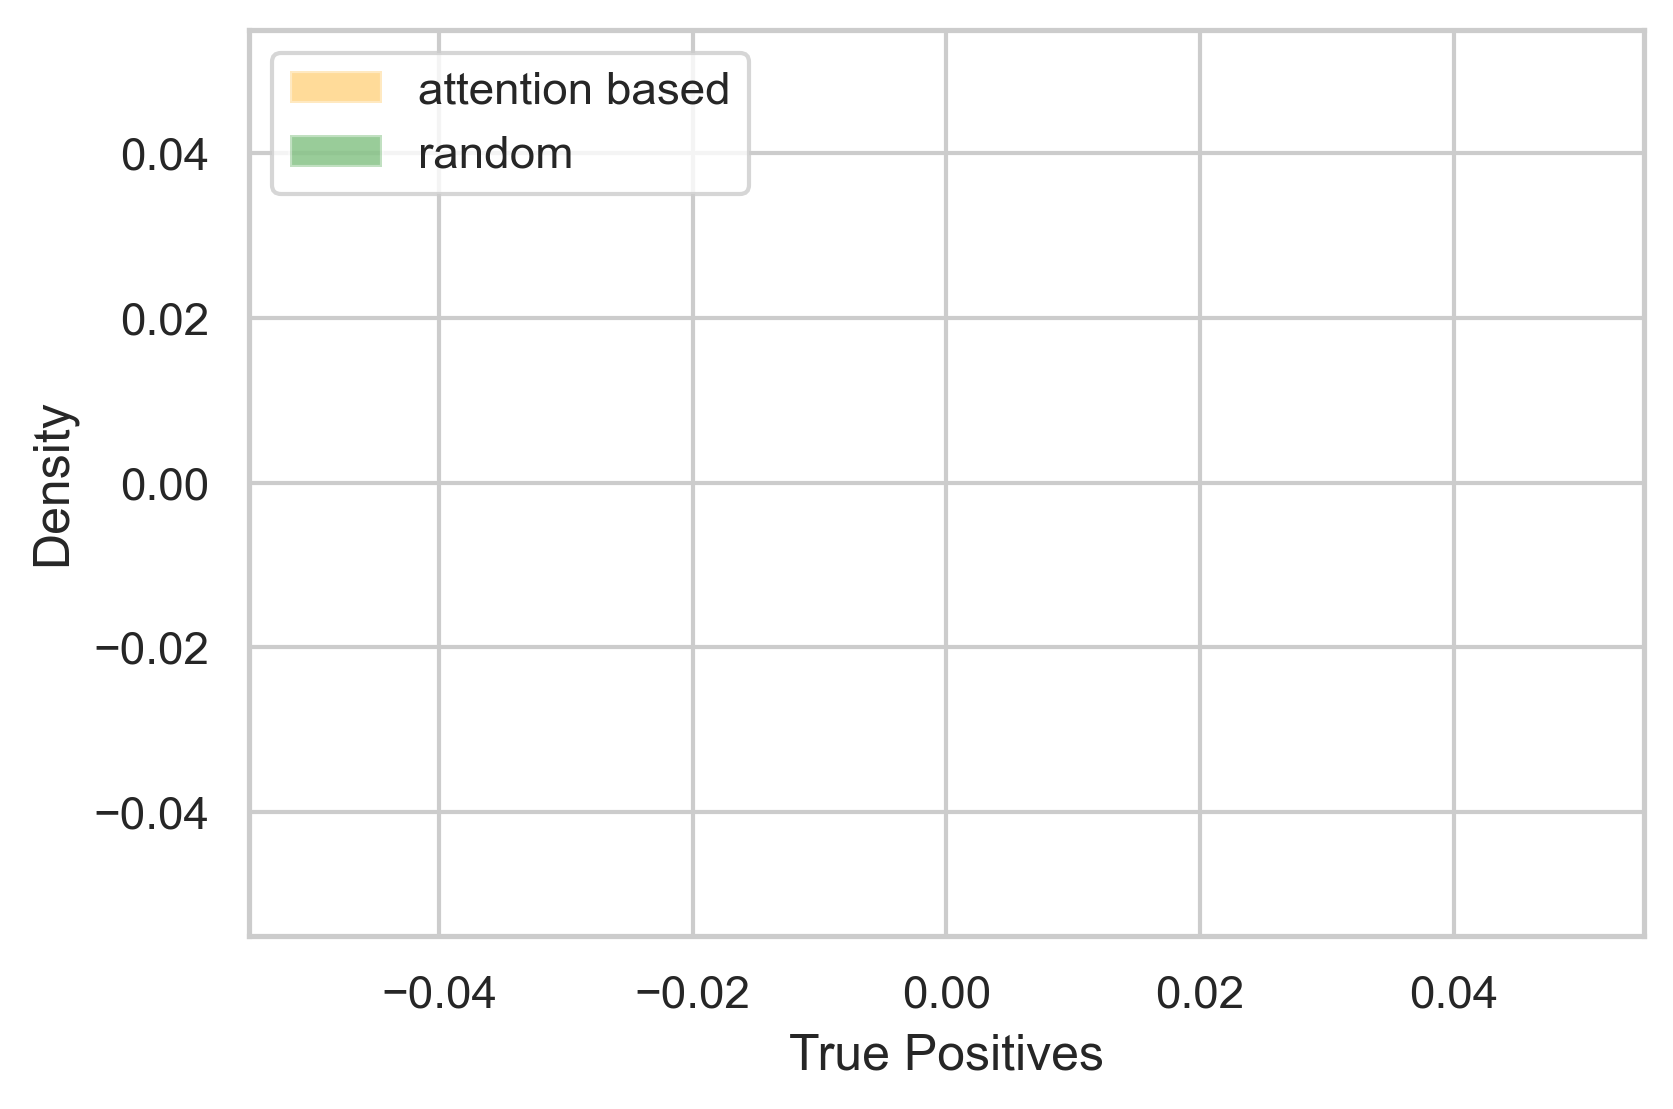

In [12]:
print(len(all_results))
all_scores_np = np.array(all_results)
all_pred = np.array(all_pred_results)
all_random = np.array(all_random_results)
all_random_30 = np.array(all_random_30_results)
all_tn_30_np = np.array(all_tn_30)
all_fp_30_np = np.array(all_fp_30)

all_fn_30_np = np.array(all_fn_30)
all_tp_30_np = np.array(all_tp_30)
all_tn_np = np.array(all_tn)
all_fp_np = np.array(all_fp)
all_fn_np = np.array(all_fn)
all_tp_np = np.array(all_tp)



np.set_printoptions(suppress=True)
print('confusion predictions:')
print(np.round(np.array([[all_tp_np.mean(), all_fp_np.mean()],
       [all_fn_np.mean(), all_tn_np.mean()]]),4))

print('confusion random')
print(np.round(np.array([[all_tp_30_np.mean(), all_fp_30_np.mean()],
       [all_fn_30_np.mean(), all_tn_30_np.mean()]]),4))

df_all_tp_np = pd.DataFrame(np.stack([all_tp_np]).T, columns=["y"])
df_all_tp_30_np = pd.DataFrame(np.stack([all_tp_30_np.flatten()]).T, columns=["y"])
sn.distplot(df_all_tp_np, kde=False , norm_hist=True,color='orange', bins=20)
sn.distplot(df_all_tp_30_np, kde=False , norm_hist=True,color='green', bins=20)
plt.legend(['attention based','random'])
plt.xlabel('True Positives')
plt.ylabel('Density')




In [ ]:

for name, pearsonR in tqdm(list(zip(names, pearsonRs))):
    if pearsonR < 0.82: continue

    attention_weights_name = os.path.join('data',input_name, name, 'default/version_0/attn_weights_test_head_0.csv')
    if not os.path.exists(attention_weights_name):
        attention_weights_name = os.path.join('data',input_name, name, 'FLAP/default/version_0/attn_weights_test_head_0.csv')

    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))

    for query_idx, query_sequence in enumerate(query_sequences):
        try:
            seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
            complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
            complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
            if complex_ids == []: continue
            target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
            target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
            comp_and_target_ids = list(set(complex_ids) | set(target_ids))
            has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
            has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
            sequences = has_target['sequence'].tolist()

            if name + 'query_idx' + str(query_idx) not in saved_alignments.keys():
                print('missing ', name)
                continue
            all_alignments = saved_alignments[name + 'query_idx' + str(query_idx)]
            if all_alignments == []: continue

            scores = [alignment['score'] for alignment in all_alignments]
            top3_misalginment_scores = sorted(list(set(-np.array(scores) + len(query_sequence))))[:3]
            misaligned_allowance = top3_misalginment_scores[-1]

            alignment_ratio = 0.01  # This is the percentage of a sequence that needs to be aligned to the original sequence to include its binding sites

            row = csv_input.loc[csv_input['proteins_seq'] == query_sequence]
            random_results = []
            pred_results=[]
            results= []
            for top_k in [3, 5, 10, 20, 30, 50]:
                attention = np.array(row.values.tolist())
                attention = attention[:, 7:len(query_sequence) + 7].astype(float)[:top_k]
                attention_mean = attention.mean(axis=0)
                attention_mean = attention_mean / attention_mean.max()
                top_prediction_idx = attention_mean.argsort()[-3:][::-1]
                top_predictions = np.zeros_like(attention_mean)
                top_predictions[np.array(top_prediction_idx)] = 1

                repeats = int(np.ceil(attention.shape[0] / 30))
                is_binding_site = binding_site_annotation(all_alignments, has_target_frame=has_target,
                                                          input_sequence=query_sequence, misaligned_allowance=misaligned_allowance)

                rand_tpr3 = 0
                n_rand = 30
                for i in range(n_rand):
                    random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                    random_int = np.zeros_like(is_binding_site)
                    random_int[random_int_idx] = 1
                    random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                    true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                    rand_tpr3 += true_pos_random3
                rand_tpr3 = rand_tpr3/n_rand
                random_int_idx = np.random.randint(0, len(is_binding_site), size=3)
                random_int = np.zeros_like(is_binding_site)
                random_int[random_int_idx] = 1
                random_intAvgP = average_precision_score(is_binding_site, random_int)
                random_int_true_positive_rate = precision_score(is_binding_site, random_int)
                continuous_preds_dist1 = realign(attention_mean,is_binding_site.astype(int), dist=1)
                continuous_preds_dist2 = realign(attention_mean,is_binding_site.astype(int), dist=2)
                continuous_preds_dist3 = realign(attention_mean,is_binding_site.astype(int), dist=3)
                preds_dist1 = realign(top_predictions,is_binding_site.astype(int), dist=1)
                preds_dist2 = realign(top_predictions,is_binding_site.astype(int), dist=2)
                preds_dist3 = realign(top_predictions,is_binding_site.astype(int), dist=3)
                random_int_dist1 = realign(random_int,is_binding_site.astype(int), dist=1)
                random_int_dist2 = realign(random_int,is_binding_site.astype(int), dist=2)
                random_int_dist3 = realign(random_int,is_binding_site.astype(int), dist=3)
                continuous_random = np.random.rand(len(attention_mean))
                continuous_random = continuous_random/continuous_random.max()
                random_cont_dist1 = realign(continuous_random,is_binding_site.astype(int), dist=1)
                random_cont_dist2 = realign(continuous_random,is_binding_site.astype(int), dist=2)
                random_cont_dist3 = realign(continuous_random,is_binding_site.astype(int), dist=3)
                avgROC = average_precision_score(is_binding_site, top_predictions)
                avgROC1 = average_precision_score(is_binding_site, continuous_preds_dist1)
                avgROC2 = average_precision_score(is_binding_site, continuous_preds_dist2)
                avgROC3 = average_precision_score(is_binding_site, continuous_preds_dist3)
                random_avgROC = average_precision_score(is_binding_site, continuous_random)
                random_avgROC1 = average_precision_score(is_binding_site, random_cont_dist1)
                random_avgROC2 = average_precision_score(is_binding_site, random_cont_dist2)
                random_avgROC3 = average_precision_score(is_binding_site, random_cont_dist3)
                avgP = average_precision_score(is_binding_site, top_predictions)
                avgP1 = average_precision_score(is_binding_site, continuous_preds_dist1)
                avgP2 = average_precision_score(is_binding_site, continuous_preds_dist2)
                avgP3 = average_precision_score(is_binding_site, continuous_preds_dist3)
                random_avgP = average_precision_score(is_binding_site, continuous_random)
                random_avgP1 = average_precision_score(is_binding_site, random_cont_dist1)
                random_avgP2 = average_precision_score(is_binding_site, random_cont_dist2)
                random_avgP3 = average_precision_score(is_binding_site, random_cont_dist3)
                true_pos_rate = precision_score(is_binding_site.astype(int), top_predictions.astype(int))
                true_pos_rate1 = precision_score(is_binding_site.astype(int), preds_dist1.astype(int))
                true_pos_rate2 = precision_score(is_binding_site.astype(int), preds_dist2.astype(int))
                true_pos_rate3 = precision_score(is_binding_site.astype(int), preds_dist3.astype(int))
                true_pos_random = precision_score(is_binding_site.astype(int), random_int.astype(int))
                true_pos_random1 = precision_score(is_binding_site.astype(int), random_int_dist1.astype(int))
                true_pos_random2 = precision_score(is_binding_site.astype(int), random_int_dist2.astype(int))
                true_pos_random3 = precision_score(is_binding_site.astype(int), random_int_dist3.astype(int))
                visualization = np.concatenate(
                    [np.tile(is_binding_site, (repeats, 1)), np.tile(attention_mean, (repeats, 1)), attention], axis=0)
                ax = sn.heatmap(visualization, annot=False, cmap='pink', cbar=False)
                plt.title(
                    f'name: {name} \n prot: {query_idx} pearsonR: {round(pearsonR, 2)} avgP: {round(avgP, 2)} randAvgP: {round(random_avgP, 2)} TPR: {round(true_pos_rate, 2)} randTPR: {round(true_pos_random, 2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)}')
                ax.hlines([repeats * 2], *ax.get_xlim())
                plt.savefig(
                    f'{output_name}/{name}_prot{query_idx}_top{top_k}_pearsonR{round(pearsonR, 2)}_avgP{round(avgP, 2)}_tpr{round(true_pos_rate, 2)}.jpg')
                plt.show()
                plt.clf()
                #break

                random_results.append(rand_tpr3)
                pred_results.append(true_pos_rate3)
                results.append(true_pos_rate3 - rand_tpr3)
            all_results.append(results)
            all_pred_results.append(pred_results)
            all_random_results.append(random_results)
        except Exception as e:
            print(e)
            print('For name ', name)

